Importing necessary modules

In [27]:
!pip install statsmodels joblib

In [ ]:
'''
Python code for spam classification
'''

'''
importing required modules:
Copied all the modules...
will read about them when using
'''

import numpy as np
import pandas as pd 
import matplotlib.pyplot as pt 
%matplotlib inline
import seaborn as sns

import statsmodels.api as sm 


from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.externals import joblib
import os.path
import spacy

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# !python -m spacy download en_core_web_md

In [ ]:
class SMSBase:
	_nlp = spacy.load("en") #Loading a pretrained spacy model to assign vectors to words
	def __init__(self, filename, frac = 0.8):
		self._file = filename
		self._features = ['class', 'context']
		self._raw_data = pd.read_csv(self._file, sep='\t', names=self._features)
		# Text file to csv conversion
		# self.txt2csv(filename,self._features)
		self._format_context()
		# Adding two new features: len(text) and number of words in text
		self._extract_features()
		self._groupby_feature = self._raw_data.groupby('class')
		self._count_by_featuers = self._groupby_feature.count().to_dict()['context']
		self._split_train_test(frac)
	def _format_context(self):
		self._raw_data['context'] = self._raw_data['context'].map(lambda text: text.rsplit('\n')[0])
		self._raw_data['context'] =  self._raw_data['context'].map(lambda text : text.replace(',', ' ,') if ',' in text else text)
	def _extract_features(self):
		self._raw_data['len'] = self._raw_data['context'].map(lambda text: len(text))
		self._raw_data['nwords'] = self._raw_data['context'].map(lambda text: len(text.split(' ')))
		self._features = self._raw_data.columns
	def txt2csv(self, filename, columns):
		f = open(filename, 'r')
		for i, x in enumerate(f):
			r = x.split('\t')
			self._raw_data.loc[i, 'class'] = r[0]
			self._raw_data.loc[i, 'context'] = r[1]
	def _split_train_test(self, frac):
		self._df_train = self._raw_data.sample(frac = frac)
		self._df_test = self._raw_data.drop(self._df_train.index)
	def describe(self):
		print('-'*20)
		print(self._raw_data.head())
		print('-' * 20)
		print(self._raw_data.describe())
		print('-' * 20)
		print(self._groupby_feature.describe())
	def create_lemma(self, c):
		tokens = self._nlp(c)
		return [token.lemma_ for token in tokens]
	
	def create_tokens(self, c):
		tokens = self._nlp(c)
		return [token for token in tokens]

class Util:

	def check_model(model, df_train, df_test, X_feature, y_feature):

		classes_train = np.unique(df_train[y_feature].values).tolist()
		classes_test = np.unique(df_test[y_feature].values).tolist()

		assert(classes_train == classes_test)

		classes = classes_train

		X_train = df_train[X_feature].values.tolist()
		X_test = df_test[X_feature].values.tolist()

		y_train = df_train[y_feature].values.tolist()
		y_test = df_test[y_test].values.tolist()

		y_train_pred = model.fit(X_train,y_train).predict(X_train)
		y_test_pred = model.fit(X_train, y_train).predict(X_test)

		return report_cm(y_train, y_train_pred, y_test, y_test_pred, classes)
	
	def report_cm(y_train, y_train_pred, y_test, y_test_pred, classes):

		fig, axs = plt.subplots(1, 2, figsize = (10, 5))

		cm_test_matrix = confusion_matrix(y_test, y_test_pred)
		dtest_cm = pd.DataFrame(cm_test_matrix, index = classes, columns = classes)
		ax = sns.heatmap(dtest_cm, annot = True, ax = axs[0], square = True)
		ax.set_title('Test CM')

		cm_train_matrix = confusion_matrix(y_train, y_train_pred)
		dtrain_cm = pd.DataFrame(cm_train_matrix, index = classes, columns = classes)
		ax = sns.heatmap(dtrain_cm, annot = True, ax = axs[1], square = True)
		ax.set_title('Train CM')

		print('-' * 20 + 'Testing Performance' + '-' * 20)
		print(classification_report(y_test, y_test_pred, target_names = classes))
		print('acc: ', metrics.accuracy_score(y_test, y_test_pred))

		print('-' * 20 + 'Training Performance' + '-' * 20)
		print(classification_report(y_train, y_train_pred, target_names = classes))
		print('acc: ', metrics.accuracy_score(y_train, y_train_pred))
	
	def plot_CDF(p,
				 ax,
				 deltax = None,
				 deltay = 0.25,
				 xlim = [0, 1],
				 ylim = [0, 1],
				 xlabel = 'x',
				 xlog = False,
				 ylog = False):
		
		df = pd.DataFrame(p, columns = [xlabel])
		display(df.describe())
		ecdf = sm.distributions.ECDF(p)
		x = ecdf.x
		y = ecdf.y
		assert len(x) == len(y)
		if deltax is not None:
			x_ticks = np.arange(xlim[0], xlim[1] + deltax, deltax)
			ax.set_xticks(x_ticks)

		ax.set_xlabel(xlabel)
		ax.set_xlim(xlim[0], xlim[1])
		ax.vlines(np.mean(p), min(y), max(y), color='red', label='mean', linewidth=2)
		ax.vlines(np.median(p), min(y), max(y), color='orange', label='median', linewidth=2)
		ax.vlines(np.mean(p) + 2 * np.std(p), min(y), max(y), color='blue', label='mean + 2 * std', linewidth=2)
		ax.vlines(np.mean(p) + 3 * np.std(p), min(y), max(y), color='green', label='mean + 3 * std', linewidth=2)

		y_ticks = np.arange(ylim[0], ylim[1] + deltay, deltay)
		ax.set_ylabel('CDF')
		ax.set_yticks(y_ticks)
		ax.set_ylim(ylim[0], ylim[1])

		if xlog is True:
			ax.set_xscale('log')

		if ylog is True:
			ax.set_yscale('log')

		ax.grid(which='minor', alpha=0.5)
		ax.grid(which='major', alpha=0.9)

		ax.legend(loc=4)

		sns.set_style('whitegrid')
		sns.regplot(x=x, y=y, fit_reg=False, scatter=True, ax = ax)
	

	def plot_class_dist(df, by):

		x_features = df.columns.drop(by)
		assert len(x_features) > 0

		x_features = x_features[0]
		# dist = df.groupby(by).count()
		dist = df.groupby(by)[x_features].size()/ len(df)
		display(dist)
		sns.barplot(x = dist.index, y = dist.values)
	
	def plot_boxplot(df, by, y, ax):
		ax = sns.boxplot(x=by, y=y, data=df[[by,  y]], ax = ax)
		ax.set_yscale('log')
		
	def dump_pickle(obj,filename):
		joblib.dump(obj, filename)
		
	def load_pickle(filename):
		return joblib.load(filename)

# Classification Approach

I will update the notes as I implement the code
1. CountVectorizer - We need to convert the text to vector format and countvectorizer is one method of doing so. We get term counts of the text using this. Analyzer is passed as self.create_lemmas to count the occurences of lemmas instead of words
2. Truncated SVD - to reduce the number of features. Similar to PCA, but data is not centred before dimensionality reduction
3. StratifiedKFold - to perform K Fold Cross Validation - it takes care to distribute the unbalanced class samples equally among train test splits.
4. We tend to create pipeline based on the model we choose and similarly the parameters for gridsearchCV. Pipeline basically creates a work-flow which can be applied for sklearn modules.
5. We can validate our model by passing the pipeline directly into cross_val_score.
6. During Training, first, we perform GridSearchCV for best parameter settings, then we utilise the best model to fit the training data.

In [ ]:
class SMSClassification(SMSBase):
    __pipelines = {}
    __params = {}
    __format_model_file_name = '{}_model.pkl'

    def __init__(self, filename, frac=0.8):
        super().__init__(filename, frac)
        
        self.__bow = CountVectorizer(analyzer=self.create_lemma)
        self.__tfidf = TfidfTransformer()
        
        self.__svd = TruncatedSVD(n_components=50)

        self.__cv = StratifiedKFold(n_splits=5)
        
        self.__default_params = {
            'tfidf__use_idf': (True, False),
            'bow__analyzer': (self.create_lemma, self.create_tokens),
        }
        
        self.__X = self._df_train['context'].values.tolist()
        self.__y = self._df_train['class'].values.tolist()
        
   
    def __create_pipeline(self, option='NB'):
                        
        if (option in self.__pipelines) is False:
                        
            if option is 'NB':
                classifier = MultinomialNB()
                pipeline = Pipeline([
                    ('bow', self.__bow),
                    ('tfidf', self.__tfidf),
                    ('classifier', classifier),
                ])

            elif option is 'SVM':
                classifier = SVC()
                pipeline = Pipeline([
                    ('bow', self.__bow),
                    ('tfidf', self.__tfidf),
                    ('svd', self.__svd),
                    ('classifier', classifier),
                ])
                
            elif option is 'RFT':
                classifier = RandomForestClassifier()
                pipeline = Pipeline([
                    ('bow', self.__bow),
                    ('tfidf', self.__tfidf),
                    ('svd', self.__svd),
                    ('classifier', classifier),
                ])
                
            else:
                classifier = MultinomialNB()

            self.__pipelines[option] = pipeline
            
            return pipeline

        else:
            return self.__pipelines[option]
            
            
    def __create_grid_search_params(self, option='NB'):
        
        if (option in self.__params) is False:
            if option is 'SVM':
                params = [
                    {
                      'classifier__C': [1, 10, 100, 1000], 
                      'classifier__kernel': ['linear']
                    },
                    {
                      'classifier__C': [1, 10, 100, 1000], 
                      'classifier__gamma': [0.001, 0.0001], 
                      'classifier__kernel': ['rbf']
                    },
                ]

                # merging two list of paramaters on the same list.
#                 params = list(map(lambda m : {**m, **self.__default_params}, params))
            else:
                params = self.__default_params

            self.__params[option] = params
        else:
            params = self.__params[option]
            
        return params

        
        
    def validate(self, option='NB'):
        
        pipeline = self.__create_pipeline(option)
        if pipeline is not None:            
            scores = cross_val_score(pipeline, 
                                     self.__X, 
                                     self.__y, 
                                     scoring='accuracy', 
                                     cv=self.__cv, 
                                     verbose=1, 
                                     n_jobs=-1)

            print('scores={}\nmean={} std={}'.format(scores, scores.mean(), scores.std()))
        else:
            print ("pipeline does not exist!")

        
    def train(self, option='NB', dump=True):
        
        pipeline = self.__create_pipeline(option)
        if pipeline is not None:
            
            params = self.__create_grid_search_params(option)
            
            grid = GridSearchCV(
                pipeline, 
                params, 
                refit=True, 
                n_jobs=-1, 
                scoring='accuracy', 
                cv=self.__cv)

            model = grid.fit(self.__X, self.__y)
            
            display('(Grid Search) Best Parameters:', )
            display(pd.DataFrame([model.best_params_]))

            if dump:
                model_file_name = self.__format_model_file_name.format(option)
                Util.dump_pickle(model, model_file_name)
                
            return model
                
        else:
            print('pipeline does not exist!')
            return None

    
    def test(self, X=None, model=None, model_file=None):
        
        if X is None:
            X = self.__X
        
        if model is None and model_file is None:
            print('Please, use either model or model_file')
            return []
        
        if model_file is not None and os.path.isfile(model_file):
            model = Util.load_pickle(model_file)
            print('{} file was loaded'.format(model_file))
            return model.predict(X)
        
        if model is not None:
            return model.predict(X)
        else:
            return []

In [ ]:
sms = SMSClassification('SMSSpamCollection')

In [ ]:
sms.describe()

--------------------
  class                                            context  len  nwords
0   ham  Go until jurong point , crazy.. Available only...  112      21
1   ham                      Ok lar... Joking wif u oni...   29       6
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...  155      28
3   ham  U dun say so early hor... U c already then say...   49      11
4   ham  Nah I don't think he goes to usf , he lives ar...   62      14
--------------------
               len       nwords
count  5572.000000  5572.000000
mean     80.808507    16.060122
std      60.175592    11.829450
min       2.000000     1.000000
25%      36.000000     7.000000
50%      62.000000    13.000000
75%     123.000000    24.000000
max     910.000000   175.000000
--------------------
          len                                      ... nwords                         
        count        mean        std   min    25%  ...    min   25%   50%   75%    max
class                                      

class
ham     0.865937
spam    0.134063
Name: context, dtype: float64

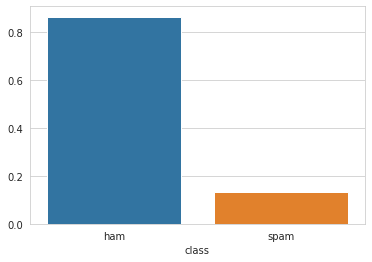

In [ ]:
Util.plot_class_dist(sms._raw_data, 'class')

In [ ]:
sms._raw_data

,class,context,len,nwords
0,ham,"Go until jurong point , crazy.. Available only...",112,21
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28
3,ham,U dun say so early hor... U c already then say...,49,11
4,ham,"Nah I don't think he goes to usf , he lives ar...",62,14
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,161,31
5568,ham,Will ü b going to esplanade fr home?,36,8
5569,ham,"Pity , * was in mood for that. So...any other ...",58,11
5570,ham,The guy did some bitching but I acted like i'd...,125,26


,number of words
count,5572.000000
mean,16.060122
std,11.829450
min,1.000000
25%,7.000000
50%,13.000000
75%,24.000000
max,175.000000


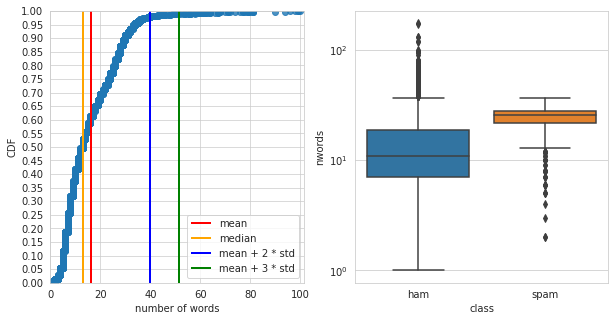

In [ ]:
n_words_in_context = sms._raw_data['nwords'].values.tolist()

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize = (10, 5))

Util.plot_CDF(n_words_in_context, 
         axs[0], 
         xlim=[0, np.mean(n_words_in_context) + 3 * np.std(n_words_in_context) + 50],
         deltay = 0.05,
         ylim=[0, 1.00], xlabel='number of words')
Util.plot_boxplot(sms._raw_data, 'class','nwords', axs[1])

Observations:

1. 50% of context has less than or equal to 20 words.
2. 99% of context has less than or equal to 40 words
3. Number of words in spam is more than ham msgs.

,len of words
count,5572.000000
mean,80.808507
std,60.175592
min,2.000000
25%,36.000000
50%,62.000000
75%,123.000000
max,910.000000


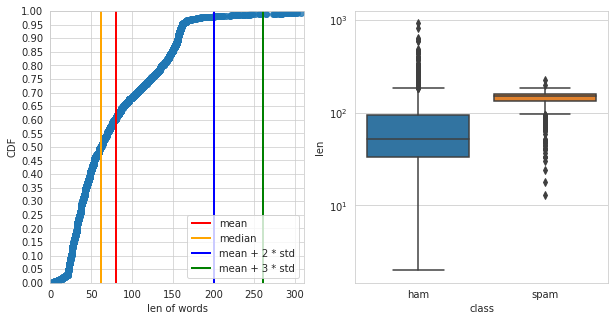

In [ ]:
len_words_in_context = sms._raw_data['len'].values.tolist()

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize = (10, 5))

Util.plot_CDF(len_words_in_context, 
         axs[0], 
         xlim=[0, np.mean(len_words_in_context) + 3 * np.std(len_words_in_context) + 50],
         deltay = 0.05,
         ylim=[0, 1.00], xlabel='len of words')
Util.plot_boxplot(sms._raw_data, 'class','len', axs[1])

1. 60% of context has len of context less/ equal to 100.
2. Almost 100% of context has len of context less/equal to 155.
3. Len of spam msgs are usually longer than normal msgs

In [ ]:
sms._raw_data[sms._raw_data['nwords']==1]['context'].values.tolist()

['Yup',
 'Thanx...',
 'Okie...',
 'Ok..',
 'Beerage?',
 'Ok...',
 'Ok...',
 'Ok...',
 'Ok...',
 '645',
 'Ok...',
 'Ok',
 'Ok.',
 'Ok...',
 'Okie...',
 'Yup...',
 'Ok...',
 'Okie',
 'Ok...',
 'Okie',
 'ALRITE',
 'Anything...',
 'Ok',
 'staff.science.nus.edu.sg/~phyhcmk/teaching/pc1323',
 'Ok...',
 'Ok.',
 'Nite...',
 'Ok.',
 'Okie',
 'Ok.',
 'Okie...',
 'G.W.R',
 'Ok',
 'Havent.',
 'Anytime...',
 'Ok...',
 'Okie',
 'Ok',
 'Yup']

In [ ]:
sms._raw_data[sms._raw_data['nwords'] == 16]['context'].values.tolist()

['Even my brother is not like to speak with me. They treat me like aids patent.',
 "I'm back &amp; we're packing the car now , I'll let you know if there's room",
 "K fyi x has a ride early tomorrow morning but he's crashing at our place tonight",
 "Its not the same here. Still looking for a job. How much do Ta's earn there.",
 "I'm still looking for a car to buy. And have not gone 4the driving test yet.",
 'Text her. If she doesnt reply let me know so i can have her log in',
 'Busy here. Trying to finish for new year. I am looking forward to finally meeting you...',
 'Here is your discount code RP176781. To stop further messages reply stop. www.regalportfolio.co.uk. Customer Services 08717205546',
 'From here after The performance award is calculated every two month.not for current one month period..',
 'Hmmm...k...but i want to change the field quickly da:-)i wanna get system administrator or network administrator..',
 'Yep , the great loxahatchee xmas tree burning of  &lt;#&gt;  sta

In [ ]:
classifiers = ['NB', 'SVM', 'RFT']


In [ ]:
for c in classifiers:
    display('-' * 40 + c + '-' * 40)
    %time sms.validate(c)

'----------------------------------------NB----------------------------------------'

['GENT! We are trying to contact you. Last weekends draw shows that you won a £1000 prize GUARANTEED. Call 09064012160. Claim Code K52. Valid 12hrs only. 150ppm', "She.s find. I sent you an offline message to know how anjola's now.", 'Wat makes some people dearer is not just de happiness dat u feel when u meet them but de pain u feel when u miss dem!!!', 'Double Mins & Double Txt & 1/2 price Linerental on Latest Orange Bluetooth mobiles. Call MobileUpd8 for the very latest offers. 08000839402 or call2optout/LF56', 'The evo. I just had to download flash. Jealous?', 'Dear reached railway. What happen to you', "Yeah that'd pretty much be the best case scenario", "Aight no rush , I'll ask jay", 'URGENT! Your mobile No 077xxx WON a £2 ,000 Bonus Caller Prize on 02/06/03! This is the 2nd attempt to reach YOU! Call 09066362206 ASAP! BOX97N7QP , 150ppm', 'MMM ... Fuck .... Merry Christmas to me', "Mah b , I'll pick it up tomorrow", 'HMV BONUS SPECIAL 500 pounds of genuine HMV vouchers to be wo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


scores=[0.94145357 0.93943472 0.94549125]
mean=0.9421265141318976 std=0.0025179390220551644
CPU times: user 13.7 s, sys: 655 ms, total: 14.3 s
Wall time: 2min 2s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.0min finished


'----------------------------------------SVM----------------------------------------'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


['GENT! We are trying to contact you. Last weekends draw shows that you won a £1000 prize GUARANTEED. Call 09064012160. Claim Code K52. Valid 12hrs only. 150ppm', "She.s find. I sent you an offline message to know how anjola's now.", 'Wat makes some people dearer is not just de happiness dat u feel when u meet them but de pain u feel when u miss dem!!!', 'Double Mins & Double Txt & 1/2 price Linerental on Latest Orange Bluetooth mobiles. Call MobileUpd8 for the very latest offers. 08000839402 or call2optout/LF56', 'The evo. I just had to download flash. Jealous?', 'Dear reached railway. What happen to you', "Yeah that'd pretty much be the best case scenario", "Aight no rush , I'll ask jay", 'URGENT! Your mobile No 077xxx WON a £2 ,000 Bonus Caller Prize on 02/06/03! This is the 2nd attempt to reach YOU! Call 09066362206 ASAP! BOX97N7QP , 150ppm', 'MMM ... Fuck .... Merry Christmas to me', "Mah b , I'll pick it up tomorrow", 'HMV BONUS SPECIAL 500 pounds of genuine HMV vouchers to be wo

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.0min finished


'----------------------------------------RFT----------------------------------------'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


['GENT! We are trying to contact you. Last weekends draw shows that you won a £1000 prize GUARANTEED. Call 09064012160. Claim Code K52. Valid 12hrs only. 150ppm', "She.s find. I sent you an offline message to know how anjola's now.", 'Wat makes some people dearer is not just de happiness dat u feel when u meet them but de pain u feel when u miss dem!!!', 'Double Mins & Double Txt & 1/2 price Linerental on Latest Orange Bluetooth mobiles. Call MobileUpd8 for the very latest offers. 08000839402 or call2optout/LF56', 'The evo. I just had to download flash. Jealous?', 'Dear reached railway. What happen to you', "Yeah that'd pretty much be the best case scenario", "Aight no rush , I'll ask jay", 'URGENT! Your mobile No 077xxx WON a £2 ,000 Bonus Caller Prize on 02/06/03! This is the 2nd attempt to reach YOU! Call 09066362206 ASAP! BOX97N7QP , 150ppm', 'MMM ... Fuck .... Merry Christmas to me', "Mah b , I'll pick it up tomorrow", 'HMV BONUS SPECIAL 500 pounds of genuine HMV vouchers to be wo

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


scores=[0.96567968 0.95491252 0.95962315]
mean=0.9600717810677434 std=0.0044071069323437925
CPU times: user 14.1 s, sys: 651 ms, total: 14.8 s
Wall time: 2min 6s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.1min finished


The validation above is only 2 fold, and hence is a bit unrealiable. U can perform more folds, with better computation

**Training**
1. GridSearchCV is used to select the best set of hyper-params for each of the model.
2. Each model is saved as a pickle file with the optimum parameters

In [ ]:
models = {}

for c in classifiers:
    display('-' * 40 + c + '-' * 40)
    %time models[c] = sms.train(c)

'----------------------------------------NB----------------------------------------'

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


'(Grid Search) Best Parameters:'

,bow__analyzer,tfidf__use_idf
0,<bound method SMSBase.create_lemma of <__main_...,True


CPU times: user 2min 20s, sys: 6.74 s, total: 2min 27s
Wall time: 13min 13s


'----------------------------------------SVM----------------------------------------'

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


'(Grid Search) Best Parameters:'

,classifier__C,classifier__kernel
0,1000,linear


CPU times: user 5min 43s, sys: 21.7 s, total: 6min 5s
Wall time: 38min 7s


'----------------------------------------RFT----------------------------------------'

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


'(Grid Search) Best Parameters:'

,bow__analyzer,tfidf__use_idf
0,<bound method SMSBase.create_lemma of <__main_...,True


CPU times: user 2min 23s, sys: 6.54 s, total: 2min 30s
Wall time: 13min 56s


In [ ]:
sms._pipelines

In [ ]:
for c in classifiers:
    display('-' * 40 + c + '-' * 40)
    model_file = '{}_model.pkl'.format(c)
    %time r = sms.test(model_file=model_file)
    display(r)

Evaluation 

Evaluating the performance using confusion matrix. Used four metrics like precision recall, f1 score, accuracy.


In [ ]:
for c in classifiers:
    display('-' * 40 + c + '-' * 40)
    model_file = '{}_model.pkl'.format(c)
    model = Util.load_pickle(model_file)
    Util.report_classification(model, 
                               sms._df_train, 
                               sms._df_test, 
                               'context', 
                               'class')e

**Observations**

1. It is important to consider False Positives i.e number of Relevant msgs classified as spam. It is lowest for NB classifier.
2. Recall here implies, number of False negatives to be zero, i,e no spam should be allowed into the inbox. For this case, SVM performs the best.

# Part 2 Deep Learning


Here, we implement deep learning based approach using pytorch framework

During this experiment:

> 
1.   Implemented classification in DL from scratch 
2.   Used pytorch framework to build layers
3.   Can either start the model training from scratch or use pre-trained glove vectors

>
Architecure:
>
1. Embedding layer
2. Dense layer
3. LSTM for RNN layer
4. Dense Layer






In [28]:
from torch.nn.functional import one_hot
from torchtext import data 
import torch
import torch.nn as nn 
from torchtext.data import Field 
from torchtext.data import Dataset, Example
from torchtext.data import BucketIterator
from torchtext.vocab import FastText
from torchtext.vocab import CharNGram 
from torch.autograd import Variable

In [ ]:
sms = SMSClassification('SMSSpamCollection')

total = sms._raw_data
corpus = total['context'].values.tolist()
labels = total['class'].values.tolist()
labels = pd.Series(labels)
labels = labels.apply(lambda x: 0 if x=='spam' else 1)
labels = np.array(labels)

In [ ]:
sum(labels==1), sum(labels==0)

(4825, 747)

1. we load english dictionary using spacy models
2. new_corpus consists of tokenized data from original context. We can alternatively use string.split(), but tokenization is more better approach
3. vocab_count contains term count for each unique token generated.
4. vocab_to_int consists of index for each term, we added padding, unknown tokens also into vocab_to_int.

In [ ]:
# nlp = spacy.load('en')
# new_corpus = []
# for data in corpus:
#     new_corpus.append(nlp(data.lower()))
new_corpus = corpus
from collections import Counter

vocabs = [vocab for seq in new_corpus for vocab in seq.split()]

vocab_count = Counter(vocabs)
vocab_count = vocab_count.most_common(len(vocab_count))

vocab_to_int = {word : index+2 for index, (word, count) in enumerate(vocab_count)}
vocab_to_int.update({'__PADDING__': 0}) # index 0 for padding
vocab_to_int.update({'__UNKNOWN__': 1})

vectored_seqs = []
for seq in new_corpus:
    vectored_seqs.append([vocab_to_int.get(str(word), 1) for word in seq])

In [ ]:
len(vocab_count), len(vocab_to_int)

(15132, 15134)

1. We need sequence lengths, to be given as input to our model. The sequences are padded to maximum length.

In [ ]:
seq_lengths = torch.LongTensor(list(map(len, vectored_seqs)))
seq_tensor = Variable(torch.zeros((len(vectored_seqs), seq_lengths.max()))).long()
for i, (seq, slen) in enumerate(zip(vectored_seqs, seq_lengths)):
    seq_tensor[i, :slen] = torch.LongTensor(seq)

In [ ]:
seq_lengths.max()

tensor(910)

1. We implement a DataLoader object which gives seq_tensor, seq_lengths, labels as its attributes.
2. We need atleast tow functions __iter__ and __next__ inorder to implement a custom dataloader.
3. __iter__ function initialises the iterator to batchsampler.
4. __next__ function retrieves next item in the iterator

In [ ]:
import torch.utils.data.sampler as splr

class DataLoader(object):
    def __init__(self, seq_tensor, seq_lengths, label_tensor, batch_size):
        self.batch_size = batch_size
        self.seq_tensor = seq_tensor
        self.seq_lengths = seq_lengths
        self.label_tensor = label_tensor
        self.sampler = splr.BatchSampler(splr.RandomSampler(self.label_tensor), self.batch_size, False)
        self.sampler_iter = iter(self.sampler)
    
    def __iter__(self):
        self.sampler_iter = iter(self.sampler)
        return self
    
    def _next_index(self):
        return next(self.sampler_iter)
    
    def __next__(self):
        index = self._next_index()
        subset_seq_tensor = self.seq_tensor[index]
        subset_seq_length = self.seq_lengths[index]
        subset_label_tensor = self.label_tensor[index]

        subset_seq_lengths, perm_idx = subset_seq_length.sort(0, descending=True)
        subset_seq_tensor = subset_seq_tensor[perm_idx]
        subset_label_tensor = subset_label_tensor[perm_idx]

        return subset_seq_tensor, subset_seq_lengths, subset_label_tensor
    
    def __len__(self):
        return len(self.sampler)

Created Train, test, valid sets from the initial datasets. Here there might be a problem of class-unbalanced sets. A better strategy might be to use stratified K fold for train and valid

In [ ]:
shuffled_idx = torch.randperm(labels.shape[0])

seq_tensor = seq_tensor[shuffled_idx]
seq_lenghts = seq_lengths[shuffled_idx]
label = labels[shuffled_idx]

# divide data into 3 sets
PCT_TRAIN = 0.7 # 70% of data will be train set 
PCT_VALID = 0.2 # 20% of data will be validation set
# The rest of data will be test set

length = len(label)
train_seq_tensor = seq_tensor[:int(length*PCT_TRAIN)] 
train_seq_lengths = seq_lengths[:int(length*PCT_TRAIN)]
train_label = label[:int(length*PCT_TRAIN)]

valid_seq_tensor = seq_tensor[int(length*PCT_TRAIN):int(length*(PCT_TRAIN+PCT_VALID))] 
valid_seq_lengths = seq_lengths[int(length*PCT_TRAIN):int(length*(PCT_TRAIN+PCT_VALID))] 
valid_label = label[int(length*PCT_TRAIN):int(length*(PCT_TRAIN+PCT_VALID))]

test_seq_tensor = seq_tensor[int(length*(PCT_TRAIN+PCT_VALID)):]
test_seq_lengths = seq_lengths[int(length*(PCT_TRAIN+PCT_VALID)):]
test_label = label[int(length*(PCT_TRAIN+PCT_VALID)):]

print(train_seq_tensor.shape) # torch.Size([4200, 30772])
print(valid_seq_tensor.shape) # torch.Size([1199, 30772])
print(test_seq_tensor.shape) # torch.Size([601, 30772])

# Instantiate data loaders
batch_size = 80
train_loader = DataLoader(train_seq_tensor, train_seq_lengths, train_label, batch_size)
valid_loader = DataLoader(valid_seq_tensor, valid_seq_lengths, valid_label, batch_size)
test_loader = DataLoader(test_seq_tensor, test_seq_lengths, test_label, batch_size)

torch.Size([3900, 910])
torch.Size([1114, 910])
torch.Size([558, 910])


Using pretrained Glove embeddings instead of weight initialisation from scratch

1. Glove embeddings are downloaded from [here](https://nlp.stanford.edu/projects/glove/).
2. We use 50 dimensional embeddings for our case.
3. The glove file contains a 50 dimnensional vector for each word. Hence, we parse the .txt file and store the 50-d vector.
4. bcolz array is used as it allows compresssion either in-memory or on disk.
5. The embeddings obtained are stored.
6. install bcolz using `!pip install bcolz`

In [ ]:
# import bcolz
# import pickle
# glove_path = '.'

ModuleNotFoundError: ignored

In [ ]:
# words = []
# idx = 0
# word2idx = {}
# vectors = bcolz.carray(np.zeros(1), rootdir=f'{glove_path}/6B.50.dat', mode='w')

# with open(f'{glove_path}/glove.6B.50d.txt', 'rb') as f:
#     for l in f:
#         line = l.decode().split()
#         word = line[0]
#         words.append(word)
#         word2idx[word] = idx
#         idx += 1
#         vect = np.array(line[1:]).astype(np.float)
#         vectors.append(vect)
    
# vectors = bcolz.carray(vectors[1:].reshape((400000, 50)), rootdir=f'{glove_path}/6B.50.dat', mode='w')
# vectors.flush()
# pickle.dump(words, open(f'{glove_path}/6B.50_words.pkl', 'wb'))
# pickle.dump(word2idx, open(f'{glove_path}/6B.50_idx.pkl', 'wb'))

In [ ]:
# vectors = bcolz.open(f'{glove_path}/6B.50.dat')[:]
# words = pickle.load(open(f'{glove_path}/6B.50_words.pkl', 'rb'))
# word2idx = pickle.load(open(f'{glove_path}/6B.50_idx.pkl', 'rb'))

# glove = {w: vectors[word2idx[w]] for w in words}

In [ ]:
# matrix_len = len(vocab_to_int)
# weights_matrix = np.zeros((matrix_len, 50))
# words_found = 0

# for i, word in enumerate(vocab_to_int):
#     try: 
#         weights_matrix[i] = glove[word]
#         words_found += 1
#     except KeyError:
#         weights_matrix[i] = np.random.normal(scale=0.6, size=(50, ))

In [ ]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class SpamClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_size, n_layers,
                 dropout_lstm = 0.1, dropout = 0.1):
        
        super().__init__()
        self.output_size = output_size
        self.vocab_size = vocab_size
        
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout = dropout_lstm, batch_first = True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(self.hidden_dim, self.output_size)
        self.act = nn.Sigmoid()

    def forward(self, x, seq_lengths):
        embedded_seq_tensor = self.embedding(x)
        packed_input = pack_padded_sequence(embedded_seq_tensor, seq_lengths.cpu().numpy(), batch_first = True)
        packed_output, (ht, ct) = self.lstm(packed_input, None)
        output, input_sizes = pad_packed_sequence(packed_output, batch_first=True)

        last_idxs = (input_sizes - 1).to(device)
        # print(last_idxs.view(-1, 1).unsqueeze(2).repeat(1, 1, self.hidden_dim))
        output = torch.gather(output, 1, last_idxs.view(-1, 1).unsqueeze(2).repeat(1, 1, self.hidden_dim)).squeeze()
        # print(output.size())
        output = self.dropout(output)
        output = self.fc(output).squeeze()
               
        # sigmoid function
        output = self.act(output)

        return output

In [ ]:
import numpy as np
epochs = 4
counter = 0
print_every = 10
clip = 5
device = 'cpu'
net = SpamClassifier(vocab_size = len(vocab_to_int), embedding_dim = 100, hidden_dim = 15, output_size = 2, n_layers = 2, dropout_lstm=0.2, dropout = 0.2)
# Uncomment this to load pretrained weights
# net.embedding.weights.data.copy_(weights_matrx)
optimizer = torch.optim.Adam(net.parameters(),lr = 0.03)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,\
                                                       mode = 'min', \
                                                      factor = 0.5,\
                                                      patience = 2)

# train for some number of epochs
val_losses = []
for e in range(epochs):
    net.train()
    scheduler.step(e)

    for seq_tensor, seq_tensor_lengths, label in iter(train_loader):
        counter += 1
               
        seq_tensor = seq_tensor.to(device)
        seq_tensor_lengths = seq_tensor_lengths.to(device)
        label = torch.LongTensor(label)
        label = label.to(device)
 
        # get the output from the model
        output = net(seq_tensor, seq_tensor_lengths)

        # get the loss and backprop
        # print(output)
        # break
        loss = criterion(output, label)
        optimizer.zero_grad() 
        loss.backward()
        
        # prevent the exploding gradient
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            
            val_losses_in_itr = []
            sums = []
            sizes = []
            
            net.eval()
            
            for seq_tensor, seq_tensor_lengths, label in iter(valid_loader):

                seq_tensor = seq_tensor.to(device)
                seq_tensor_lengths = seq_tensor_lengths.to(device)
                label = torch.LongTensor(label)
                label = label.to(device)
                output = net(seq_tensor, seq_tensor_lengths)
                
                # losses
                val_loss = criterion(output, label)     
                val_losses_in_itr.append(val_loss.item())
                predictions = output.argmax(axis = 1)

            accuracy = sum(predictions == label) / len(label)
            
            print("Epoch: {:2d}/{:2d}\t".format(e+1, epochs),
                    "Steps: {:3d}\t".format(counter),
                    "Loss: {:.6f}\t".format(loss.item()),
                    "Val Loss: {:.6f}\t".format(np.mean(val_losses_in_itr)),
                    "Accuracy: {:.3f}".format(accuracy))


Epoch:  1/ 4	 Steps:  10	 Loss: 0.432970	 Val Loss: 0.471897	 Accuracy: 0.811
Epoch:  1/ 4	 Steps:  20	 Loss: 0.413893	 Val Loss: 0.468816	 Accuracy: 0.865
Epoch:  1/ 4	 Steps:  30	 Loss: 0.413494	 Val Loss: 0.468959	 Accuracy: 0.797
Epoch:  1/ 4	 Steps:  40	 Loss: 0.450880	 Val Loss: 0.468549	 Accuracy: 0.865
Epoch:  2/ 4	 Steps:  50	 Loss: 0.525806	 Val Loss: 0.469039	 Accuracy: 0.770
Epoch:  2/ 4	 Steps:  60	 Loss: 0.438358	 Val Loss: 0.468670	 Accuracy: 0.838
Epoch:  2/ 4	 Steps:  70	 Loss: 0.413369	 Val Loss: 0.468882	 Accuracy: 0.797
Epoch:  2/ 4	 Steps:  80	 Loss: 0.438347	 Val Loss: 0.468734	 Accuracy: 0.824
Epoch:  2/ 4	 Steps:  90	 Loss: 0.425850	 Val Loss: 0.468514	 Accuracy: 0.865
Epoch:  3/ 4	 Steps: 100	 Loss: 0.450831	 Val Loss: 0.468800	 Accuracy: 0.811
Epoch:  3/ 4	 Steps: 110	 Loss: 0.488310	 Val Loss: 0.468798	 Accuracy: 0.811
Epoch:  3/ 4	 Steps: 120	 Loss: 0.388359	 Val Loss: 0.468506	 Accuracy: 0.865
Epoch:  3/ 4	 Steps: 130	 Loss: 0.488306	 Val Loss: 0.468721	 Ac

In [ ]:
test_losses = []
sums = []
sizes = []

net.eval()

test_losses = []
for seq_tensor, seq_tensor_lengths, label in iter(test_loader):

    seq_tensor = seq_tensor.to(device)
    seq_tensor_lengths = seq_tensor_lengths.to(device)
    label = torch.LongTensor(label)
    label = label.to(device)
    output = net(seq_tensor, seq_tensor_lengths)

    # losses
    test_loss = criterion(output, label)     
    test_losses.append(test_loss.item())

    # accuracy
    predictions = output.argmax(axis = 1)

            

accuracy = sum(predictions == label) / len(label)
print("Test Loss: {:.6f}\t".format(np.mean(test_losses)),
      "Accuracy: {:.3f}".format(accuracy))

Test Loss: 0.456626	 Accuracy: 0.872
